# Plot ali.\*.gz from mono

- 목적: frame당 phone이 정렬되어 있는 ali.\*.gz 파일을 파이썬으로 시각화하기
    - acoustic model이 훈련되면서 (at each alignment), 어떻게 align이 되어가는지를 시각화
    - 전체 모델 (1.mdl to 39.mdl)에 대한 영상 제작
- 인풋:
    - ali.\*.gz
    - phones.txt
    - \*.mdl (e.g. 0.mdl, 1.mdl, ... )
    - \*.ark (e.g. raw_mfcc_trans1.1.ark)
- 아웃풋:
    - mfcc w/ phone plot
    
### **Open in nbviewer**: [Link](http://nbviewer.jupyter.org/github/jaekookang/kaldi_tools/blob/master/tools/plot_ali_gz_from_mono/plot_ali_from_mono_all.ipynb)

In [3]:
%matplotlib inline
import IPython
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from IPython.display import HTML, Audio
import os
import re
import glob
import numpy as np
import subprocess

KALDI_HOME= '/home/kaldi'
mfcc = './prep_out/data/data/raw_mfcc_data.1.ark'

## Make alignments

In [2]:
%%bash
# make alignments
[ -d ./align ] && rm -rf ./align/*
# cp -r models/* align/
for i in `ls models`; do
    mkdir -p align/$i
    . ./align_si_from_model.sh --cmd run.pl --nj 1 prep_out/data prep_out/lang models/$i align/$i
    echo '$i is created'
done

bash: feature type is delta
bash: aligning data in prep_out/data using model from models/1, putting alignments in align/1
steps/diagnostic/analyze_alignments.sh --cmd run.pl prep_out/lang align/1
analyze_phone_length_stats.py: WARNING: optional-silence sil is seen only 0.0% of the time at utterance begin.  This may not be optimal.
analyze_phone_length_stats.py: WARNING: optional-silence sil is seen only 9.090909090909092% of the time at utterance end.  This may not be optimal.
steps/diagnostic/analyze_alignments.sh: see stats in align/1/log/analyze_alignments.log
bash: done aligning data.
$i is created
bash: feature type is delta
bash: aligning data in prep_out/data using model from models/10, putting alignments in align/10
steps/diagnostic/analyze_alignments.sh --cmd run.pl prep_out/lang align/10
steps/diagnostic/analyze_alignments.sh: see stats in align/10/log/analyze_alignments.log
bash: done aligning data.
$i is created
bash: feature type is delta
bash: aligning data in prep_out/da

cp: cannot stat 'models/1/1.occs': No such file or directory


In [4]:
def get_ali_dict(phones, final_mdl, ali_gz, verbose=False):
    # retrieve ali.*.gz
    result = subprocess.run([KALDI_HOME+'/src/bin/show-alignments',
                               phones, final_mdl, 'ark:gunzip -c '+ali_gz+'|'],
                               stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=False)
    if verbose:
        print('Commandline: {}'.format(' '.join(result.args)))
    out = result.stdout.decode('utf-8').strip()
    out = [o for o in out.split('\n') if o != '']
    
    ali_dict = {}
    # get nframes from odd number indices
    for i, t in enumerate(out[::2]):
        key = t.split('  ')[0].strip()
        frames = [tt.strip(']|[| ').split(' ') for tt in t.split('  ')[1].split('] [')]
        nframes = [len(f) for f in frames]
        ali_dict[key] = {'nframes': nframes}
    # get phone labels from even number indices    
    for i, t in enumerate(out[1::2]):
        key = t.split('  ')[0].strip()
        labs_raw = re.split(r'\s+', t.strip())[1:]
        labs = [re.sub('_.*','',b) for b in labs_raw] # removing context
        ali_dict[key].update({'labels':labs, 'labels_raw':labs_raw})
    # e.g. ali_dict['lib-0001-fc-008-part']['labels']    
    return ali_dict

def plot_boxes(fid, ali_dict, trim_dict, title=None, which_lab=None):
    # draw boxes for all phone labels or a single phone
    # e.g., plot_boxes('lib-0001-fc-008-part', ali_dict, trim_dict)
    # e.g., plot_boxes('lib-0001-fc-008-part', ali_dict, trim_dict, which_lab='sil')
    mfcc = trim_dict[fid] # frame x dim
    nframes = ali_dict[fid]['nframes']
    frames = sum(nframes)
    labels = ali_dict[fid]['labels']
    patch_list = []
    
    if title:
        ax.set_title(title)
    
    if which_lab:
        uq = [which_lab]
        cm_list = ['red']
        
        for q, col in zip(uq, cm_list):
            x = 0
            for frm, lab in zip(nframes, labels):
                if re.match(q, lab):
                    myPatch = patches.FancyBboxPatch((x, ylim[0]), frm, ylim[1], fill=False,
                                                        boxstyle=patches.BoxStyle("Round", pad=0.3),
                                                        edgecolor=col)
                    ax.add_patch(myPatch)
                    patch_list.append(myPatch)
                    ax.text(x + frm/2, ylim[1]/2, lab, 
                            color=col, fontsize=15)
                    x += frm
                else:
                    x += frm
        
    else:
        uq = list(set(labels))
        cmap = cm.nipy_spectral
        cm_list = np.linspace(0, 255, len(uq))
        cm_list = np.floor(cm_list).astype(np.int)

        for q, col in zip(uq, cm_list):
            x = 0
            col_hex = matplotlib.colors.rgb2hex(cmap(col))
            pad = np.random.randn()*2
            for frm, lab in zip(nframes, labels):
                if q==lab:
                    myPatch = patches.FancyBboxPatch((x, ylim[0]), frm, ylim[1], fill=False,
                                                        boxstyle=patches.BoxStyle("Round", pad=0.3),
                                                        edgecolor=col)
                    ax.add_patch(myPatch)
                    patch_list.append(myPatch)
                    ax.text(x + frm/2, ylim[1]/2+pad, lab, 
                            color=col_hex, fontsize=15)
                    x += frm
                else:
                    x += frm    
    return trim_dict[fid], patch_list                
# img, patch_list = plot_boxes('lib-0001-fc-008-part', ali_dict, trim_dict, title='39.mdl', which_lab='sil');

## Load MFCCs

In [5]:
# TODO: Preprocess alig.*.gz --> ali_dict (align), trim_dict (mfcc)
# retrieve MFCCs
result = subprocess.run([KALDI_HOME+'/src/featbin/copy-feats', 
                        'ark:'+mfcc, 'ark,t:'], stdout=subprocess.PIPE)
out = result.stdout.decode('utf-8').strip()
trim = [i.split('[\n') for i in out.split(']')]
trim = [t for t in trim if t != ['']]

trim_dict = {}
for ii, t in enumerate(trim):
    key = t[0].strip()
    val = [np.array(row.strip().split(' ')).astype(np.float) for row in t[1].split('\n')]
    val = np.array(val)
    trim_dict.update({key: val})
print(trim_dict.keys())    

dict_keys(['lib-0001-fc-001', 'lib-0001-fc-002', 'lib-0001-fc-003', 'lib-0001-fc-004', 'lib-0001-fc-005', 'lib-0001-fc-006', 'lib-0001-fc-007', 'lib-0001-fc-008', 'lib-0001-fc-008-part', 'lib-0001-fc-009', 'lib-0001-fc-010'])


## Load ali.1.gz

In [52]:
![ -d ./align/log ] && rm -rf ./align/log
ali_dir = sorted([int(name) for name in os.listdir('./align') if os.path.isdir(os.path.join('./align',name))])
alidct_list = []
# -------you can try different wav files-------#
fid = 'lib-0001-fc-002'
# fid = 'lib-0001-fc-001'
#---------------------------------------------#
for i in ali_dir:
    pho = 'align/'+str(i)+'/phones.txt'
    fmd = 'align/'+str(i)+'/'+str(i)+'.mdl'
    ali = 'align/'+str(i)+'/ali.1.gz'
    alidct = get_ali_dict(pho, fmd, ali, verbose=True)
    alidct_list.append(alidct)

Commandline: /home/kaldi/src/bin/show-alignments align/1/phones.txt align/1/1.mdl ark:gunzip -c align/1/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/2/phones.txt align/2/2.mdl ark:gunzip -c align/2/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/3/phones.txt align/3/3.mdl ark:gunzip -c align/3/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/4/phones.txt align/4/4.mdl ark:gunzip -c align/4/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/5/phones.txt align/5/5.mdl ark:gunzip -c align/5/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/6/phones.txt align/6/6.mdl ark:gunzip -c align/6/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/7/phones.txt align/7/7.mdl ark:gunzip -c align/7/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/8/phones.txt align/8/8.mdl ark:gunzip -c align/8/ali.1.gz|
Commandline: /home/kaldi/src/bin/show-alignments align/9/phones.txt align/9/9.mdl ark:gu

In [53]:
def make_animation(which_lab=None, save_dir=None):
    # make animation of alignments using models from 1.mdl to 39.mdl
    mfcc = trim_dict[fid] # frame x dim
    
    fig, arr = plt.subplots(2,1,figsize=(14,7), facecolor='white')
    
    arr[0].imshow(trim_dict[fid].T, origin='lower', aspect='auto', cmap='binary')
    ylim = arr[0].get_ylim();
    arr[0].set_ylabel('MFCC coeffs')
    arr[1].imshow(trim_dict[fid].T, origin='lower', aspect='auto', cmap='binary')

    # Plot alignment from 39.mdl
    ali_dict = alidct_list[-1] # 39.mdl
    nframes = ali_dict[fid]['nframes']
    frames = sum(nframes)
    labels = ali_dict[fid]['labels']
    tx_ht_pad = 1/3
    patch_pad = 0.05

    if which_lab: # some phones
        uq = [which_lab]
        cm_list = ['red']

        i = 1 # different height for each phone
        for q, col in zip(uq, cm_list):
            x = 0
            for frm, lab in zip(nframes, labels):
                if re.match(q, lab):
                    arr[0].add_patch(patches.FancyBboxPatch((x, ylim[0]), frm, ylim[1], fill=False,
                                                        boxstyle=patches.BoxStyle("Round", pad=patch_pad),
                                                        edgecolor=col))
                    arr[0].text(x + frm/2, ylim[1] - i*tx_ht_pad - 1, lab, 
                            color=col, fontweight='bold', fontsize=15)
                    x += frm
                else:
                    x += frm
            i += 1

    else: # all phones
        uq = list(set(labels))
        cmap = cm.nipy_spectral
        cm_list = np.linspace(0, 255, len(uq))
        cm_list = np.floor(cm_list).astype(np.int)

        i = 1 # different height for each phone
        for q, col in zip(uq, cm_list):
            x = 0
            col_hex = matplotlib.colors.rgb2hex(cmap(col))
            pad = np.random.randn()*2
            for frm, lab in zip(nframes, labels):
                if q==lab:
                    arr[0].add_patch(patches.FancyBboxPatch((x, ylim[0]), frm, ylim[1], fill=False,
                                                        boxstyle=patches.BoxStyle("Round", pad=patch_pad),
                                                        edgecolor=col_hex))
                    arr[0].text(x + frm/2, ylim[1] - i*tx_ht_pad - 1, lab, 
                            color=col_hex, fontweight='bold', fontsize=12)
                    x += frm
                else:
                    x += frm
            i += 1
        
    def load_plot(n_frame):
        # This function animates each frame
        ali_dict = alidct_list[n_frame]
        nframes = ali_dict[fid]['nframes']
        frames = sum(nframes)
        labels = ali_dict[fid]['labels']
        plt.suptitle('Top: model=39, Bottom: model={}'.format(ali_dir[n_frame]), y=0.995, fontsize=15)
        
        # initialize plot
        arr[1].clear()
        arr[1].imshow(trim_dict[fid].T, origin='lower', aspect='auto', cmap='binary')
        arr[1].set_ylabel('MFCC coeffs')
        
        if which_lab: # some phones
            uq = [which_lab]
            cm_list = ['red']

            i = 1 # different height for each phone
            for q, col in zip(uq, cm_list):
                x = 0
                for frm, lab in zip(nframes, labels):
                    if re.match(q, lab):
                        myPatch = patches.FancyBboxPatch((x, ylim[0]), frm, ylim[1], fill=False,
                                                            boxstyle=patches.BoxStyle("Round", pad=patch_pad),
                                                            edgecolor=col)
                        arr[1].add_patch(myPatch)
                        arr[1].text(x + frm/2, ylim[1] - i*tx_ht_pad - 1, lab, 
                                color=col, fontweight='bold', fontsize=15)
                        x += frm
                    else:
                        x += frm
                i += 1
        
        else: # all phones
            uq = list(set(labels))
            cmap = cm.nipy_spectral
            cm_list = np.linspace(0, 255, len(uq))
            cm_list = np.floor(cm_list).astype(np.int)

            i = 1 # different height for each phone
            for q, col in zip(uq, cm_list):
                x = 0
                col_hex = matplotlib.colors.rgb2hex(cmap(col))
                pad = np.random.randn()*2
                for frm, lab in zip(nframes, labels):
                    if q==lab:
                        arr[1].add_patch(patches.FancyBboxPatch((x, ylim[0]), frm, ylim[1], fill=False,
                                                            boxstyle=patches.BoxStyle("Round", pad=patch_pad),
                                                            edgecolor=col_hex))
                        arr[1].text(x + frm/2, ylim[1] - i*tx_ht_pad - 1, lab, 
                                color=col_hex, fontweight='bold', fontsize=12)
                        x += frm
                    else:
                        x += frm
                i += 1
        plt.tight_layout(pad=1.5, h_pad=1)
        return (arr,)
             
    
    anim = animation.FuncAnimation(fig, load_plot, frames=len(alidct_list), 
                                   repeat=False, interval=200)
    if save_dir:
        anim.save(filename=save_dir,
                  writer=animation.FFMpegFileWriter(fps=200))
    return HTML(anim.to_html5_video())

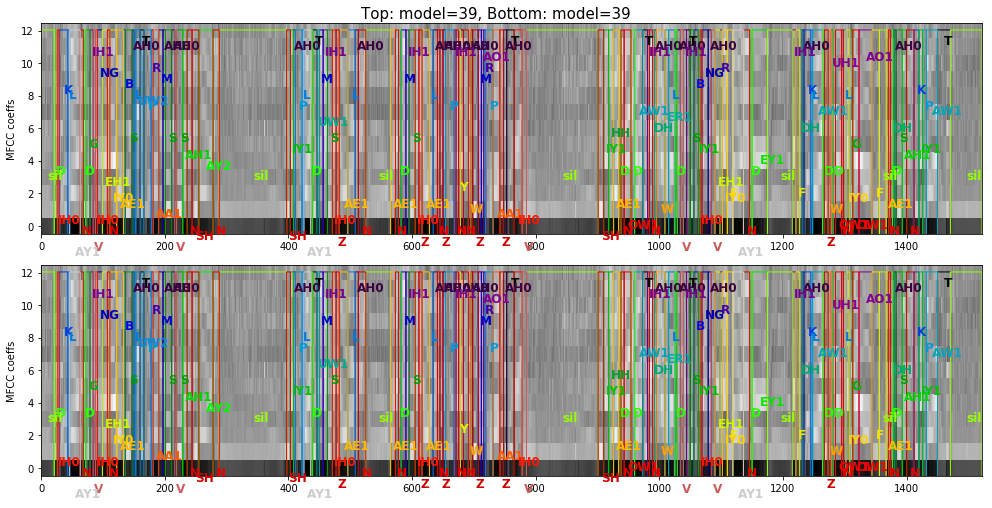

In [54]:
make_animation(save_dir='test.mp4')

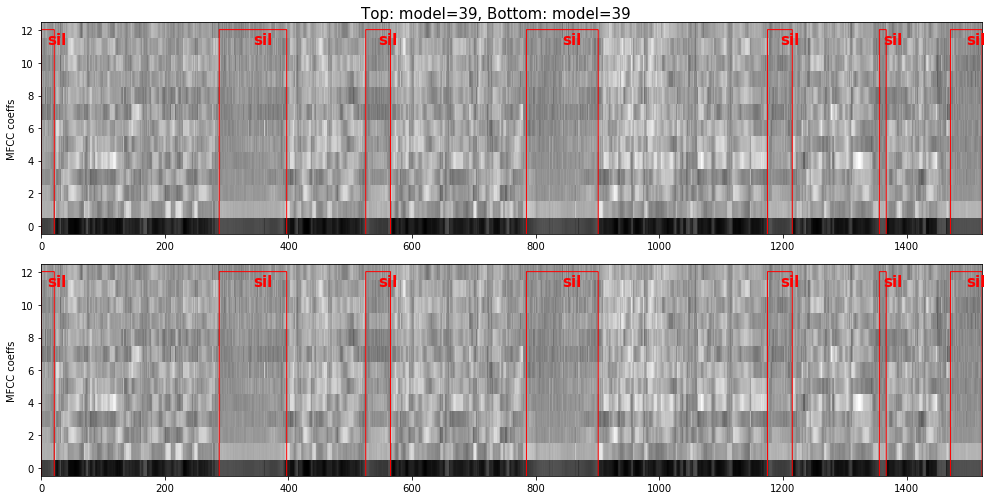

In [55]:
make_animation(which_lab='sil')

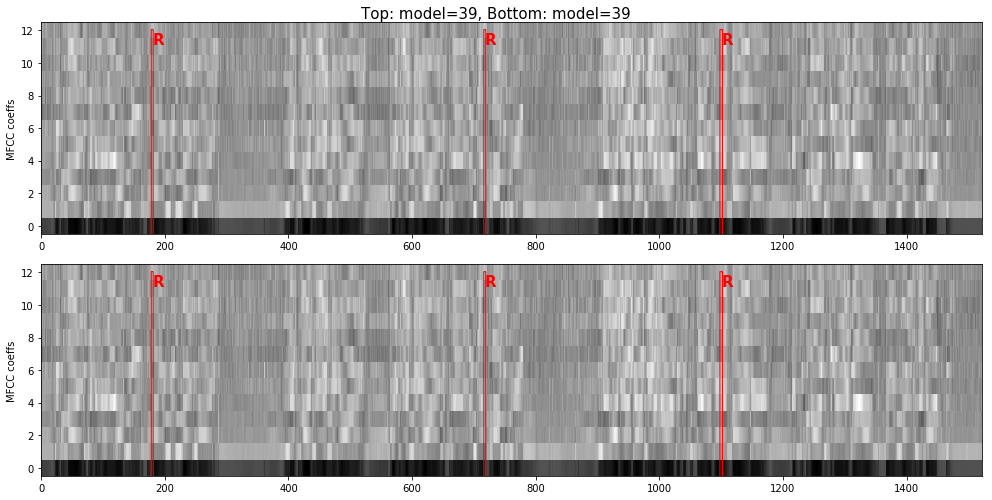

In [56]:
make_animation(which_lab='R')

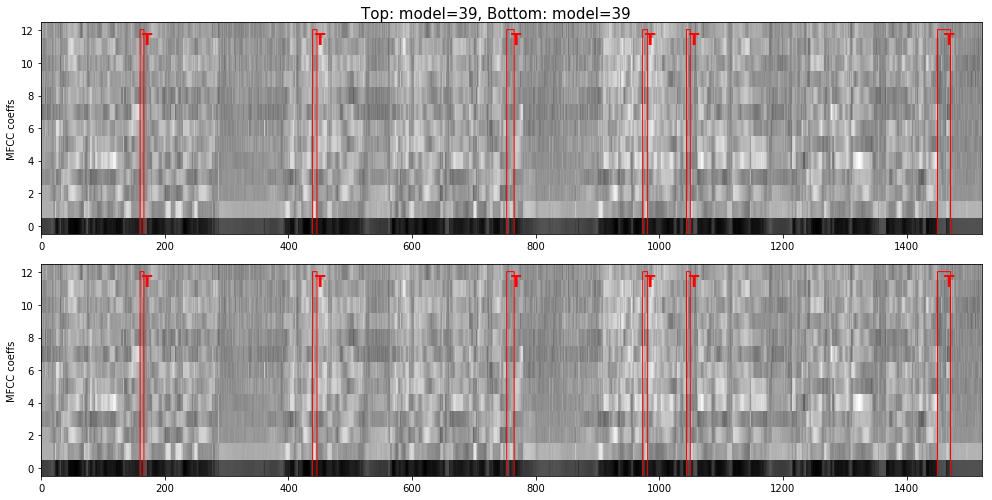

In [57]:
make_animation(which_lab='T')

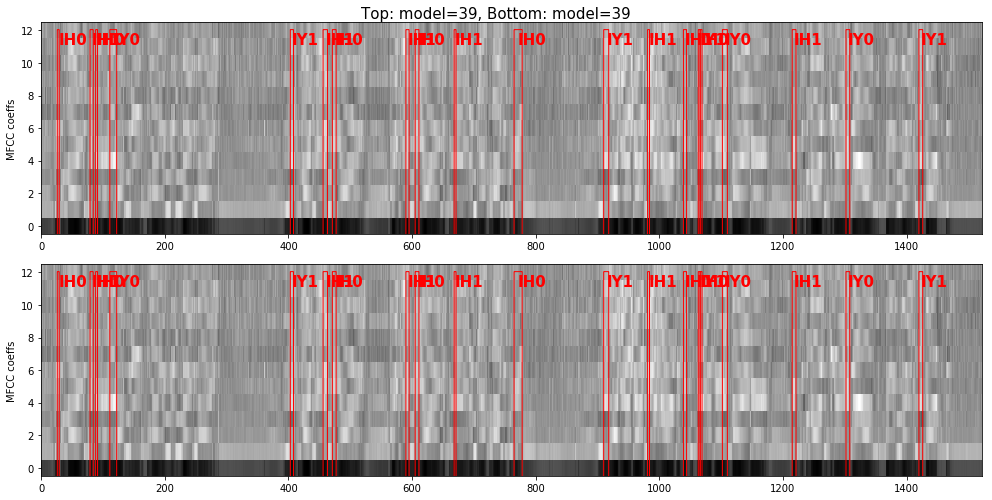

In [58]:
make_animation(which_lab='I')

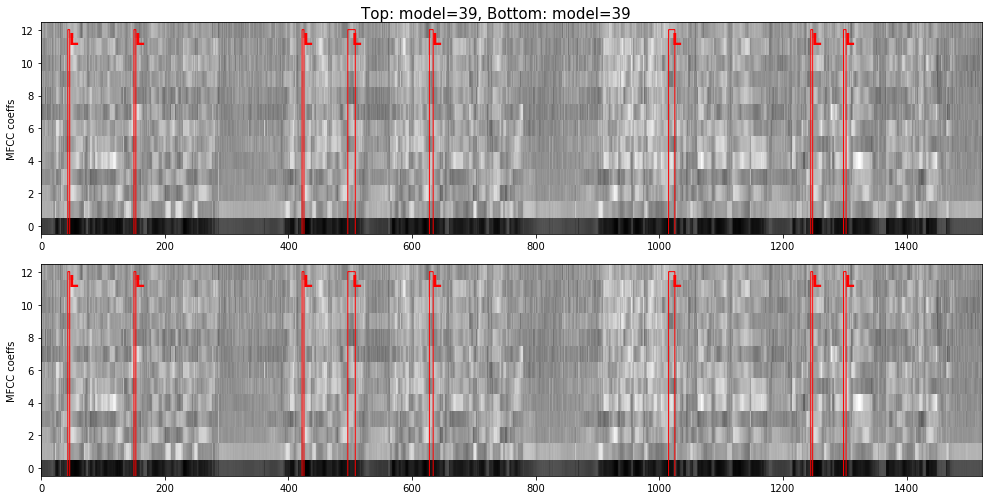

In [61]:
make_animation(which_lab='L')